# Data Engineer Exercise

## 1. What considerations would you have for managing this data?

1. Points/questions that may affect solution design and architecture
  1. Main data use cases / number of business users
  1. Types of data sources and targets
  1. Volume of the incoming and total data
  1. Velocity of data changes (stream, micro-batch, batch processing)
  1. Flexibility in toolset and primary/secondary cloud provider or internal data centers
2. The main challenges would be
  2. Build system of logging, monitoring and alerting that will garantee work of application with acceptable error levels
  2. Educate end users to work with DWH engine of choice efficiently
  2. Keep costs under control simulteniously meeting all functional and non-functional SLA

**Some general thoughts on a high level architecture**
1. All the raw files are saved perpetually in s3 data lake and can be pruned according to the corporate storage policies
  1. as a part of optimisation, source files could be converted to a store efficient formats like parquet or ORC with partitioning by day and than stored in s3
2. Apache Spark on Amazon EMR or Databricks Spark can be used as primary ELT tool to 
  2. access data from s3, external SQL databases, Redshift and to 
  2. cleanse, aggregate and send data to Redshift / s3
  2. specific pre-aggregated table depends on business needs, but from the example dataset we can build a fact table with number and duration for each kind of alert for the same 4 hour time window or 1 day window, with linkage to the detail table if user needs to go to the individual event level.
3. Amazon Redshift would be the main data warehouse engine that keeps internal data as well as providing access to federated sources in s3 via Amazon Redshift Spectrum
4. Access configuration should follow the principle of least privilage. 
  4. majority of business users get read-only access only to the datasets that are required for them to complete tasks 
  4. group of power-users have read-write permissions to necessary datasets
  4. and on the top of the pyramid are super users with full access and administrative permissions

## 2. Draft description for the device_alerts view and each of its columns
### Assumptions
* This table represents stream of alerts each of them is signaling that device is online or offline
* Looking on the RSU_ID pattern I can assume that potencially there could be billions of devices
* Type and geo location of each device could be coded in RSU_ID
* To simplify analisys every event is saved in UTC time
* Alert event is active begining from the alert time up to the receiving next alert.

### Table description
| Column Name | Data Type | Description |
| :- | :- | :- |
| timestamp_bigint | Long| Date/Time of alert in form of unix epoch with milliseconds|
| timestamp_utc | Timestamp(0)| Date/time of alert in UTC|
| rsu_id | String | Unique ID of rsu object|
| alert | String | Alert type {RSU_OFFLINE, POE_OFFLINE, SNMP_FAILURE, NONE}|

### Alert type
* RSU_OFFLINE - Road side unit is offline
* POE_OFFLINE - Power-over-Ethernet failure
* SNMP_FAILURE - Simple Network Management Protocol failure
* NONE - Road side unit works normally

## 3. What are the 4 hours in the time range with the most alerts triggered

### Simple 4 hour windowing
**4 hours between 2020/07/02 4pm and 8 pm had the most number of alerts equal to 56**

* Dataset already contains alert event in epoch format that is why we can easily split it on 4 hour buckets by deviding timestamp_bigint on number of milliseconds in this 4 hours and discarding fractional part and than moving back to epoch time but without milliseconds as we do not need such precision
* Also we need to filter out alert type NONE as accourding to the asumptions it means that RSU is alive and not actually a health alert but rather signals that previous alert has completed
* After that we just need to count events in each 'window' and get the time with the largest result

```sql
+-------------------+---+-------+
|alert_hour         |cnt|rnk_val|
+-------------------+---+-------+
|2020-07-02 20:00:00|56 |1      |
+-------------------+---+-------+

select 
  *
from 
  (
  select
    alert_hour
  , cnt
  , rank(cnt) over (partition by rsu_id order by cnt desc) as rnk_val
  from 
    (
    select 
        from_unixtime(Decimal(int(timestamp_bigint/1000/60/60/4)) * 60 * 60 * 4,"yyyy-MM-dd HH:mm:ss")  as alert_hour
      , rsu_id
      , count(*) as cnt
    from device_alerts t1
    where alert != 'NONE'
    group by 1, 2
    )
  )
where rnk_val = 1
```
### Rolling 4 hour windowing
The other approach would be to count event on the rolling basis
* For each event we look 4 hours behind using self join 
* As with previous approach all NONE alerts have to be filtered out
* Lastly counting number of alerts within 4 hour and take the largest results

**Using this approach we are getting 6 windows with 58 alerts each**
  * 2 windows at 2020-07-02
  * 1 window at 2020-07-17
  * 3 windows at 2020-07-20


```sql
+-------------------+-------------------+------------------------------------+----------+-------+
|first_alert_ts     |last_alert_ts      |rsu_id                              |cnt_alerts|rnk_val|
+-------------------+-------------------+------------------------------------+----------+-------+
|2020-07-02 19:46:12|2020-07-02 23:46:09|f943c318-26c8-45bz-zdzb-d43bz0e56690|58        |1      |
|2020-07-02 19:53:41|2020-07-02 23:51:13|f943c318-26c8-45bz-zdzb-d43bz0e56690|58        |1      |
|2020-07-17 12:19:17|2020-07-17 16:18:57|f943c318-26c8-45bz-zdzb-d43bz0e56690|58        |1      |
|2020-07-20 11:40:29|2020-07-20 15:40:09|f943c318-26c8-45bz-zdzb-d43bz0e56690|58        |1      |
|2020-07-20 11:44:20|2020-07-20 15:42:40|f943c318-26c8-45bz-zdzb-d43bz0e56690|58        |1      |
|2020-07-20 11:51:11|2020-07-20 15:50:12|f943c318-26c8-45bz-zdzb-d43bz0e56690|58        |1      |
+-------------------+-------------------+------------------------------------+----------+-------+

WITH vlt_alerts as
(
    SELECT 
      timestamp_bigint
    , timestamp_utc
    , rsu_id
    FROM device_alerts
    WHERE alert != 'NONE'
)
SELECT
  *
FROM
  (
  SELECT
    *
  , RANK(cnt_alerts) OVER (PARTITION BY rsu_id ORDER BY cnt_alerts DESC) as rnk_val
  FROM
    (
    SELECT
      min(t1.timestamp_utc) as first_alert_ts
    , t.timestamp_utc as last_alert_ts
    , t.rsu_id
    , count(*) as cnt_alerts
    FROM vlt_alerts t, vlt_alerts t1
    WHERE t.rsu_id = t1.rsu_id
    AND t1.timestamp_bigint between t.timestamp_bigint - 4*60*60*1000 and t.timestamp_bigint 
    group by 2, 3
    )
  )
WHERE rnk_val = 1  
ORDER BY 1
```

## What trends do you notice between alert types?
1. After SNMP_FAILURE always follow either POE_OFFLINE or RSU_OFFLINE
2. Overall alerts are not evenly distributed but are sporadically picking with long periods of healthy behaviour
3. SNMP_FAILURE are usually the longest alert and overall took 44% of time having only 6% occurences
4. SNMP_FAILURE and POE_OFFLINE were happening toghether during the first half of the observing period, but in the second part SNMP_FAILURE went to nothing
5. The most rare alert type is RSU_OFFLINE with only 6 occurences, that means that devices itself are more relible than network

## What tools(s) did you choose to use and why?
1. Google Bigquery (in personal project) to run a few quick queries and get the basic understanding of the dataset
2. Databricks community Spark cluster running pySpark in Jupyter notebook for the main investigation as it is quite fast; interactive; provides convinient interfaces both in Dataframe and SQL

## 4. When did the alert with the longest duration occur? 
```sql
+------------+-------------------+-------------------+------------------------------+-------+
|alert       |alert_begin_utc    |alert_end_uts      |alert_elapsed_time            |rnk_val|
+------------+-------------------+-------------------+------------------------------+-------+
|SNMP_FAILURE|2020-07-03 01:56:14|2020-07-04 22:30:08|44 hours 33 minutes 54 seconds|1      |
+------------+-------------------+-------------------+------------------------------+-------+

select 
  *
from
  (
  select
     alert
    , timestamp_utc as alert_begin_utc
    , end_timestamp_utc as alert_end_uts
    , end_timestamp_utc - timestamp_utc as alert_elapsed_time
    , rank(time_event) over (partition by rsu_id order by time_event desc) as rnk_val
  from 
    (
    select
        t.alert
      , t.rsu_id
      , timestamp_utc
      , lead(timestamp_utc) over (partition by rsu_id order by timestamp_bigint) end_timestamp_utc
      , lead(timestamp_bigint) over (partition by rsu_id order by timestamp_bigint) - timestamp_bigint as time_event
    from device_alerts t
    )
  where alert != 'NONE'
  )
where rnk_val = 1
```

## What tools(s) did you choose to use and why?
1. Spark cluster running SQL query on top of pySpark as I already had the table loaded there.

In [6]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

spark = (SparkSession
    .builder
    .appName("panasonic-assignment")
    .getOrCreate())

rsu_schema = StructType([StructField('timestamp_bigint', LongType(), True),
             StructField('timestamp_utc', TimestampType(), True),
             StructField('rsu_id', StringType(), True),
             StructField('alert', StringType(), True)])

file_path = 'dbfs:/FileStore/shared_uploads/vasilii.surov@gmail.com/device_alerts.csv'
rsu_df = spark.read.csv(file_path, header=True, schema=rsu_schema)
rsu_df.cache()
rsu_df.printSchema()

root
-- timestamp_bigint: long (nullable = true)
-- timestamp_utc: timestamp (nullable = true)
-- rsu_id: string (nullable = true)
-- alert: string (nullable = true)

In [7]:
# How many rows do we have
rsu_df.count()

Out[3]: 3479

In [8]:
# Sample data
rsu_df.orderBy('timestamp_bigint').show(18, False)

+----------------+-------------------+------------------------------------+------------+
timestamp_bigint|timestamp_utc |rsu_id |alert |
+----------------+-------------------+------------------------------------+------------+
1593583215452 |2020-07-01 06:00:15|f943c318-26c8-45bz-zdzb-d43bz0e56690|POE_OFFLINE |
1593583335091 |2020-07-01 06:02:15|f943c318-26c8-45bz-zdzb-d43bz0e56690|NONE |
1593583867309 |2020-07-01 06:11:07|f943c318-26c8-45bz-zdzb-d43bz0e56690|SNMP_FAILURE|
1593607123410 |2020-07-01 12:38:43|f943c318-26c8-45bz-zdzb-d43bz0e56690|POE_OFFLINE |
1593607170952 |2020-07-01 12:39:30|f943c318-26c8-45bz-zdzb-d43bz0e56690|NONE |
1593607574669 |2020-07-01 12:46:14|f943c318-26c8-45bz-zdzb-d43bz0e56690|SNMP_FAILURE|
1593619442468 |2020-07-01 16:04:02|f943c318-26c8-45bz-zdzb-d43bz0e56690|POE_OFFLINE |
1593619535172 |2020-07-01 16:05:35|f943c318-26c8-45bz-zdzb-d43bz0e56690|NONE |
1593619821456 |2020-07-01 16:10:21|f943c318-26c8-45bz-zdzb-d43bz0e56690|POE_OFFLINE |
1593619948069 |2020-07-01 16:12:28|f943c318-26c8-45bz-zdzb-d43bz0e56690|NONE |
1593620018361 |2020-07-01 16:13:38|f943c318-26c8-45bz-zdzb-d43bz0e56690|POE_OFFLINE |
1593620105083 |2020-07-01 16:15:05|f943c318-26c8-45bz-zdzb-d43bz0e56690|NONE |
1593620171361 |2020-07-01 16:16:11|f943c318-26c8-45bz-zdzb-d43bz0e56690|POE_OFFLINE |
1593620277183 |2020-07-01 16:17:57|f943c318-26c8-45bz-zdzb-d43bz0e56690|NONE |
1593620351447 |2020-07-01 16:19:11|f943c318-26c8-45bz-zdzb-d43bz0e56690|POE_OFFLINE |
1593620428113 |2020-07-01 16:20:28|f943c318-26c8-45bz-zdzb-d43bz0e56690|NONE |
1593620501477 |2020-07-01 16:21:41|f943c318-26c8-45bz-zdzb-d43bz0e56690|POE_OFFLINE |
1593620593939 |2020-07-01 16:23:13|f943c318-26c8-45bz-zdzb-d43bz0e56690|NONE |
+----------------+-------------------+------------------------------------+------------+
only showing top 18 rows

In [9]:
# How many alert types do we have?
rsu_df.select('alert').distinct().show()

+------------+
 alert|
+------------+
 RSU_OFFLINE|
 POE_OFFLINE|
 NONE|
SNMP_FAILURE|
+------------+

In [10]:
# Double check that file contains data only for one object
rsu_df.select('rsu_id').distinct().show(truncate=False)

+------------------------------------+
rsu_id |
+------------------------------------+
f943c318-26c8-45bz-zdzb-d43bz0e56690|
+------------------------------------+

**Data Analysys**

In [12]:
# Creating temporaty view
rsu_df.createOrReplaceTempView('device_alerts')

In [13]:
# Alert durations
spark.sql("""
select 
    t.*
  , lead(timestamp_utc) over (partition by rsu_id order by timestamp_bigint) as end_timestamp_utc
  , lead(timestamp_utc) over (partition by rsu_id order by timestamp_bigint) - timestamp_utc as elapsed_time
from device_alerts t
""").show(10, False)

+----------------+-------------------+------------------------------------+------------+-------------------+-----------------------------+
timestamp_bigint|timestamp_utc |rsu_id |alert |end_timestamp_utc |elapsed_time |
+----------------+-------------------+------------------------------------+------------+-------------------+-----------------------------+
1593583215452 |2020-07-01 06:00:15|f943c318-26c8-45bz-zdzb-d43bz0e56690|POE_OFFLINE |2020-07-01 06:02:15|2 minutes |
1593583335091 |2020-07-01 06:02:15|f943c318-26c8-45bz-zdzb-d43bz0e56690|NONE |2020-07-01 06:11:07|8 minutes 52 seconds |
1593583867309 |2020-07-01 06:11:07|f943c318-26c8-45bz-zdzb-d43bz0e56690|SNMP_FAILURE|2020-07-01 12:38:43|6 hours 27 minutes 36 seconds|
1593607123410 |2020-07-01 12:38:43|f943c318-26c8-45bz-zdzb-d43bz0e56690|POE_OFFLINE |2020-07-01 12:39:30|47 seconds |
1593607170952 |2020-07-01 12:39:30|f943c318-26c8-45bz-zdzb-d43bz0e56690|NONE |2020-07-01 12:46:14|6 minutes 44 seconds |
1593607574669 |2020-07-01 12:46:14|f943c318-26c8-45bz-zdzb-d43bz0e56690|SNMP_FAILURE|2020-07-01 16:04:02|3 hours 17 minutes 48 seconds|
1593619442468 |2020-07-01 16:04:02|f943c318-26c8-45bz-zdzb-d43bz0e56690|POE_OFFLINE |2020-07-01 16:05:35|1 minutes 33 seconds |
1593619535172 |2020-07-01 16:05:35|f943c318-26c8-45bz-zdzb-d43bz0e56690|NONE |2020-07-01 16:10:21|4 minutes 46 seconds |
1593619821456 |2020-07-01 16:10:21|f943c318-26c8-45bz-zdzb-d43bz0e56690|POE_OFFLINE |2020-07-01 16:12:28|2 minutes 7 seconds |
1593619948069 |2020-07-01 16:12:28|f943c318-26c8-45bz-zdzb-d43bz0e56690|NONE |2020-07-01 16:13:38|1 minutes 10 seconds |
+----------------+-------------------+------------------------------------+------------+-------------------+-----------------------------+
only showing top 10 rows

In [14]:
# dataframe with alert time bucketed to 4 hour window
df_hour = spark.sql("""
SELECT
    alert_hour
  , CASE WHEN alert = 'POE_OFFLINE' THEN alert_hour END as POE_OFFLINE
  , CASE WHEN alert = 'SNMP_FAILURE' THEN alert_hour END as SNMP_FAILURE  
  , CASE WHEN alert = 'RSU_OFFLINE' THEN alert_hour END as RSU_OFFLINE  
FROM 
(  
SELECT
    int(timestamp_bigint/1000/60/60/4) as alert_hour
  , alert
FROM device_alerts t1
WHERE alert != 'NONE'
)
""")
df_hour.cache()
df_hour.count()


Out[9]: 1855

In [15]:
!pip install pyspark_dist_explore

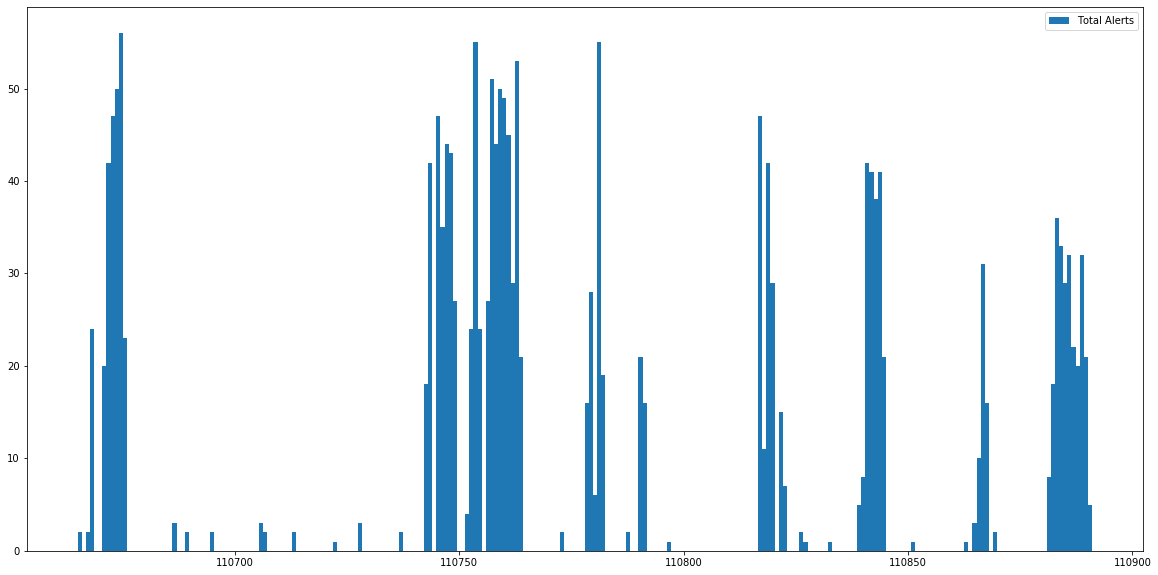

In [16]:
# Alerts distribution accros time line (all alerts toghether)

from pyspark_dist_explore import hist
import matplotlib.pyplot as plt

bins = df_hour.select('alert_hour').distinct().count()*3
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(20)
hist(ax, df_hour.select(col('alert_hour')), bins=bins)
labels = ['Total Alerts']
ax.legend(labels)

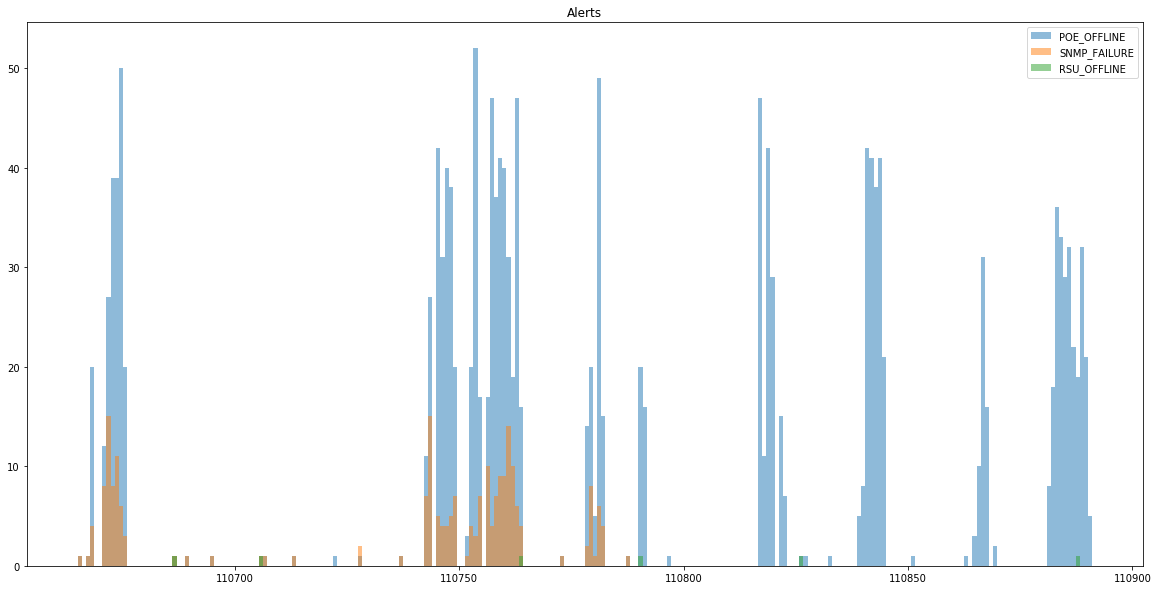

In [17]:
# Alerts distribution by type

fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(20)
POE_OFFLINE = df_hour.select(col('POE_OFFLINE'))
SNMP_FAILURE = df_hour.select(col('SNMP_FAILURE'))
RSU_OFFLINE = df_hour.select(col('RSU_OFFLINE'))

bins = df_hour.select('alert_hour').distinct().count()*3

hist(ax, [POE_OFFLINE, SNMP_FAILURE, RSU_OFFLINE], bins=bins, overlapping=True)
labels = ['POE_OFFLINE', 'SNMP_FAILURE', 'RSU_OFFLINE']
ax.legend(labels)
ax.set_title('Alerts')


In [18]:
%sql
-- Duration by alert
SELECT
  alert
, SUM(alert_duration) as total_alert_duration
, COUNT(alert) as cnt_alert_duration
, int(avg(alert_duration)) as avg_alert_duration
FROM
  (
  SELECT 
      t.alert
    , lead(timestamp_bigint) over (partition by rsu_id order by timestamp_bigint) - timestamp_bigint as alert_duration
  FROM device_alerts t
  )
GROUP BY alert



alert,total_alert_duration,cnt_alert_duration,avg_alert_duration
RSU_OFFLINE,34247,6,5707
POE_OFFLINE,274532401,1625,169047
NONE,1561377162,1624,961439
SNMP_FAILURE,1416684084,224,6324482


## 4 hours in the time range

In [20]:
# Bucketing by 4 hour
spark.sql("""
select 
  *
from 
  (
  select
    alert_hour
  , cnt
  , rank(cnt) over (partition by rsu_id order by cnt desc) as rnk_val
  from 
    (
    select 
        from_unixtime(Decimal(int(timestamp_bigint/1000/60/60/4)) * 60 * 60 * 4,"yyyy-MM-dd HH:mm:ss")  as alert_hour
      , rsu_id
      , count(*) as cnt
    from device_alerts t1
    where alert != 'NONE'
    group by 1, 2
    )
  )
where rnk_val = 1""").show(truncate=False)

+-------------------+---+-------+
alert_hour |cnt|rnk_val|
+-------------------+---+-------+
2020-07-02 20:00:00|56 |1 |
+-------------------+---+-------+

In [21]:
# Rolling windows
spark.sql("""
WITH vlt_alerts as
(
    SELECT 
      timestamp_bigint
    , timestamp_utc
    , rsu_id
    FROM device_alerts
    WHERE alert != 'NONE'
)
SELECT
  *
FROM
  (
  SELECT
    *
  , RANK(cnt_alerts) OVER (PARTITION BY rsu_id ORDER BY cnt_alerts DESC) as rnk_val
  FROM
    (
    SELECT
      min(t1.timestamp_utc) as first_alert_ts
    , t.timestamp_utc as last_alert_ts
    , t.rsu_id
    , count(*) as cnt_alerts
    FROM vlt_alerts t, vlt_alerts t1
    WHERE t.rsu_id = t1.rsu_id
    AND t1.timestamp_bigint between t.timestamp_bigint - 4*60*60*1000 and t.timestamp_bigint 
    group by 2, 3
    )
  )
WHERE rnk_val = 1  
ORDER BY 1
""").show(10, False)


+-------------------+-------------------+------------------------------------+----------+-------+
first_alert_ts |last_alert_ts |rsu_id |cnt_alerts|rnk_val|
+-------------------+-------------------+------------------------------------+----------+-------+
2020-07-02 19:46:12|2020-07-02 23:46:09|f943c318-26c8-45bz-zdzb-d43bz0e56690|58 |1 |
2020-07-02 19:53:41|2020-07-02 23:51:13|f943c318-26c8-45bz-zdzb-d43bz0e56690|58 |1 |
2020-07-17 12:19:17|2020-07-17 16:18:57|f943c318-26c8-45bz-zdzb-d43bz0e56690|58 |1 |
2020-07-20 11:40:29|2020-07-20 15:40:09|f943c318-26c8-45bz-zdzb-d43bz0e56690|58 |1 |
2020-07-20 11:44:20|2020-07-20 15:42:40|f943c318-26c8-45bz-zdzb-d43bz0e56690|58 |1 |
2020-07-20 11:51:11|2020-07-20 15:50:12|f943c318-26c8-45bz-zdzb-d43bz0e56690|58 |1 |
+-------------------+-------------------+------------------------------------+----------+-------+

## The longest duration

In [23]:
spark.sql("""
select 
  *
from
  (
  select
     alert
    , timestamp_utc as alert_begin_utc
    , end_timestamp_utc as alert_end_uts
    , end_timestamp_utc - timestamp_utc as alert_elapsed_time
    , rank(time_event) over (partition by rsu_id order by time_event desc) as rnk_val
  from 
    (
    select
        t.alert
      , t.rsu_id
      , timestamp_utc
      , lead(timestamp_utc) over (partition by rsu_id order by timestamp_bigint) end_timestamp_utc
      , lead(timestamp_bigint) over (partition by rsu_id order by timestamp_bigint) - timestamp_bigint as time_event
    from device_alerts t
    )
  where alert != 'NONE'
  )
where rnk_val = 1  
""").show(truncate=False)

+------------+-------------------+-------------------+------------------------------+-------+
alert |alert_begin_utc |alert_end_uts |alert_elapsed_time |rnk_val|
+------------+-------------------+-------------------+------------------------------+-------+
SNMP_FAILURE|2020-07-03 01:56:14|2020-07-04 22:30:08|44 hours 33 minutes 54 seconds|1 |
+------------+-------------------+-------------------+------------------------------+-------+

In [24]:

from pyspark.sql import Window
window = Window.orderBy("timestamp_bigint")
# rsu_df.orderBy('timestamp_bigint').show()
df2 = rsu_df.withColumn("next_alert", lead("alert").over(window)).withColumn("next_next_alert", lead("alert", 2).over(window)).withColumn("next_next_next_alert", lead("alert", 3).over(window))

In [25]:
df2.select('alert','next_alert', 'next_next_alert').distinct().orderBy('alert', 'next_alert', 'next_next_alert').show(100)


+------------+------------+---------------+
 alert| next_alert|next_next_alert|
+------------+------------+---------------+
 NONE| POE_OFFLINE| null|
 NONE| POE_OFFLINE| NONE|
 NONE| RSU_OFFLINE| POE_OFFLINE|
 NONE|SNMP_FAILURE| POE_OFFLINE|
 NONE|SNMP_FAILURE| RSU_OFFLINE|
 POE_OFFLINE| null| null|
 POE_OFFLINE| NONE| POE_OFFLINE|
 POE_OFFLINE| NONE| RSU_OFFLINE|
 POE_OFFLINE| NONE| SNMP_FAILURE|
 POE_OFFLINE| RSU_OFFLINE| NONE|
 RSU_OFFLINE| NONE| POE_OFFLINE|
 RSU_OFFLINE| POE_OFFLINE| NONE|
SNMP_FAILURE| POE_OFFLINE| NONE|
SNMP_FAILURE| POE_OFFLINE| RSU_OFFLINE|
SNMP_FAILURE| RSU_OFFLINE| POE_OFFLINE|
+------------+------------+---------------+